<a href="https://colab.research.google.com/github/franitaa/ADHD-EEG-Game/blob/main/ADHD_EEG_Game.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detección de ADHD a través de un juego basado en EEG

*   Francesca Rondinella (61031)
*   Nicolás Suárez Durrels (62468)

## Resumen para Dante y Facu
Para esta entrega:

*   Analizamos más en profundidad los datos, generando dataframes más útiles para lo que necesitamos (incluimos ID de sujetos, por ejemplo)
*   Agregamos las columnas de ratios de bandas de frecuencia
*   Observamos que t-SNE y UMAP para los *features* originales da un manifold que separa muy bien los dos grupos, mientras que con los ratios no separa muy bien, genera esa especie de cerebro/hongo. Para compararlo podemos ver en las secciones t-SNE y UMAP un grafico con los features extras y otro sin.
*   Vimos otras formas de sacar outliers
* Tratamos de hacer un histograma de los z-scores pero en principio no pudimos por la cantidad de datos, estamos explorando modos de reducirlos (está el código abajo, por si tienen algún consejo!)
* Generamos *heatmaps* con distintos métodos (Pearson, Kendall y Spearman), confirmando otra vez la correlación no-lineal entre la presencia de ADHD y los *features*


### Objetivos para el final
El objetivo principal es qué datos se pueden extraer de un EEG para determinar, con cierta precisión, si una persona tiene o no ADHD. Para eso queremos implementar para el final:

Objetivos de mínima:
*   Hacer un histograma de los z-scores y sacar los outliers en base a lo hallado, siguiendo el consejo de Facu
*   Separar a los sujetos (con el 100% de sus datos), en entrenamiento y testeo
* Implementar SVM y tratar de inferir, entre otras cuestiones, cuál es el sujeto que recibió tratamiento
* Analizar con técnicas como UMAP cuantos *features* bastan para tener una buena separación entre los grupos

Objetivos de máxima
* Sumar *features* que suelen usarse en análisis de EEG, como dimensión fractal, ICA, Wavelet, etc. (tenemos que pensar bien cuales, porque solo tenemos la información de bandas de frecuencia)
* Implementar otros métodos, como Gradient Boosting




## Dudas + Ideas (notas Nico y Fran)

- En vez de hacer un espectrograma, hacer un histograma
- Otras features que podemos usar, que son usuales en análisis de EEG, son: dimensión fractal, ICA, FFT, Wavelet Transform

## Imports y carga de datos

Como primer paso se importan todas las bibliotecas relevantes para el proyecto, y se importan los datos en formato csv a diccionarios, para posteriormente tratarlos como dataframes.

El dataset consta de dos carpetas que dividen a los sujetos en ADHD y no-ADHD, y cada persona tiene una carpeta de registros durante el juego controlado por BCI ("Emotiv") y por teclado ("Keyboard"). El grupo de control tiene, además de las bandas de frecuencia, las señales crudas. Estas se desestimaron ya que al no estar disponibles para el grupo ADHD, no se podían utilizar para realizar un análisis comparativo. Fueron útiles, sin embargo, para el cálculo de la frecuencia de muestreo.

A través de los timestamps que se hallan en las señales crudas se dedujo que la frecuencia de muestreo es de 125 Hz. En el paper se menciona el uso de ventanas sin solapamiento de tamaño 5 (sin especificación de unidades de medida) para la división en bandas de frecuencia. El investigador Shervin Shirmohamma confirmó que se trata de ventanas de 5 muestras, es decir que la frecuencia "neta" sería de 125/5=25 Hz.

Finalmente, a raíz de lo que se realizó durante la investigación, se agregaron cuatro columnas que relacionan las distintas bandas de frecuencia: theta/high beta, theta/low beta, alpha/high beta y alpha/low/beta.

In [1]:
pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.4 MB/s eta 0:00:00


In [2]:
#Imports
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
from google.colab import drive
import os
import numpy as np
import seaborn as sns
from scipy.signal import spectrogram
from sklearn.manifold import TSNE
from umap import UMAP
import random
import re
from sklearn.utils import resample

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
main_folder_path = '/content/drive/MyDrive/New EEG Data'

# diccionarios
adhd_emotive = {}
adhd_keyboard = {}
non_adhd_emotive = {}
non_adhd_keyboard = {}


adhd_emotive_train = {}
adhd_emotive_test = {}
non_adhd_emotive_train = {}
non_adhd_emotive_test = {}


# todos adhd: 'humam', 'said', 'zeynep', 'ayse',
adhd_training_names = ['humam', 'ayse', 'zeynep']
# todos non adhd: ''alaa', 'amer', 'sharno', 'ali', 'abdul''
non_adhd_training_names = ['sharno', 'alaa', 'ali', 'abdul', 'amer']

def is_training_file(file_name, training_names):
    return any(name in file_name.lower() for name in training_names)

def read_and_categorize_csv_files(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.csv'):
                file_path = os.path.join(root, file)
                # categoria segun path
                relative_path = os.path.relpath(file_path, main_folder_path)
                parts = relative_path.split(os.sep)

                if len(parts) >= 3:
                    category = parts[0]  # ADHD o Non-ADHD
                    subcategory = parts[2]  # Emotive o Keyboard

                    df = pd.read_csv(file_path, index_col=False).dropna(how='all')

                    df.columns = df.columns.str.strip()

                    # TODO: df sin los ratios para UMAP

                    selected_columns = ['Theta', 'Alpha', 'Low_beta', 'High_beta', 'Gamma']

                    if all(column in df.columns for column in selected_columns):
                      filtered_df  = df[selected_columns]

                      # Reemplazo 0s con NaN para evitar división por cero
                      filtered_df.replace(0, np.nan, inplace=True)

                      # Nuevas columnas
                      filtered_df['Theta/High_beta'] = filtered_df['Theta'] / filtered_df['High_beta']
                      filtered_df['Theta/Low_beta'] = filtered_df['Theta'] / filtered_df['Low_beta']
                      filtered_df['Alpha/High_beta'] = filtered_df['Alpha'] / filtered_df['High_beta']
                      filtered_df['Alpha/Low_beta'] = filtered_df['Alpha'] / filtered_df['Low_beta']

                      # NaN a 0
                      filtered_df.fillna(0, inplace=True)

                      if category == 'ADHD' and subcategory == 'Emotiv':
                          adhd_emotive[relative_path] = filtered_df
                          if is_training_file(file, adhd_training_names):
                              adhd_emotive_train[relative_path] = filtered_df
                          else:
                              adhd_emotive_test[relative_path] = filtered_df
                      elif category == 'ADHD' and subcategory == 'Keyboard':
                          adhd_keyboard[relative_path] = filtered_df
                      elif category == 'Non-ADHD' and subcategory == 'Emotive':
                          non_adhd_emotive[relative_path] = filtered_df
                          if is_training_file(file, non_adhd_training_names):
                              non_adhd_emotive_train[relative_path] = filtered_df
                          else:
                              non_adhd_emotive_test[relative_path] = filtered_df
                      elif category == 'Non-ADHD' and subcategory == 'Keyboard':
                          non_adhd_keyboard[relative_path] = filtered_df


read_and_categorize_csv_files(main_folder_path)

print("ADHD - Emotive:", adhd_emotive.keys())
print("ADHD - Emotive Train:", adhd_emotive_train.keys())
print("ADHD - Emotive Test:", adhd_emotive_test.keys())
print("ADHD - Keyboard:", adhd_keyboard.keys())
print("Non-ADHD - Emotive:", non_adhd_emotive.keys())
print("Non-ADHD - Emotive Train:", non_adhd_emotive_train.keys())
print("Non-ADHD - Emotive Test:", non_adhd_emotive_test.keys())
print("Non-ADHD - Keyboard:", non_adhd_keyboard.keys())

ADHD - Emotive: dict_keys(['ADHD/7/Emotiv/ayse nur emo 1.csv', 'ADHD/7/Emotiv/ayse nur emo 2.csv', 'ADHD/7/Emotiv/ayse nur emo 3.csv', 'ADHD/7/Emotiv/ayse nur emo 4.csv', 'ADHD/7/Emotiv/ayse nur emo 5.csv', 'ADHD/7/Emotiv/ayse nur emo 6.csv', 'ADHD/10/Emotiv/emo zeynep 1.csv', 'ADHD/10/Emotiv/emo zeynep 2.csv', 'ADHD/10/Emotiv/emo zeynep 3.csv', 'ADHD/10/Emotiv/emo zeynep 4.csv', 'ADHD/10/Emotiv/emo zeynep 5.csv', 'ADHD/10/Emotiv/emo zeynep 6.csv', 'ADHD/8/Emotiv/Humam emo 1.csv', 'ADHD/8/Emotiv/Humam emo 2.csv', 'ADHD/8/Emotiv/Humam emo 3.csv', 'ADHD/8/Emotiv/Humam emo 4.csv', 'ADHD/8/Emotiv/Humam emo 5.csv', 'ADHD/8/Emotiv/Humam emo 6.csv', 'ADHD/9/Emotiv/emo said 1.csv', 'ADHD/9/Emotiv/emo said 2.csv', 'ADHD/9/Emotiv/emo said 3.csv', 'ADHD/9/Emotiv/emo said 4.csv', 'ADHD/9/Emotiv/emo said 5.csv', 'ADHD/9/Emotiv/emo said 6.csv'])
ADHD - Emotive Train: dict_keys(['ADHD/7/Emotiv/ayse nur emo 1.csv', 'ADHD/7/Emotiv/ayse nur emo 2.csv', 'ADHD/7/Emotiv/ayse nur emo 3.csv', 'ADHD/7/Emotiv/

In [ ]:
# main_folder_path = '/content/drive/MyDrive/New EEG Data'

# adhd_emotive_original = {}
# adhd_keyboard_original = {}
# non_adhd_emotive_original = {}
# non_adhd_keyboard_original = {}

# adhd_emotive_with_ratios = {}
# adhd_keyboard_with_ratios = {}
# non_adhd_emotive_with_ratios = {}
# non_adhd_keyboard_with_ratios = {}

# def read_and_categorize_csv_files(directory):
#     for root, dirs, files in os.walk(directory):
#         for file in files:
#             if file.endswith('.csv'):
#                 file_path = os.path.join(root, file)
#                 # Category based on path
#                 relative_path = os.path.relpath(file_path, main_folder_path)
#                 parts = relative_path.split(os.sep)

#                 if len(parts) >= 4:
#                     category = parts[0]  # ADHD or Non-ADHD
#                     subject_id = parts[1]  # Numbered folder (1-6 for Non-ADHD, 7-10 for ADHD)
#                     subcategory = parts[2]  # Emotive or Keyboard

#                     df = pd.read_csv(file_path, index_col=False).dropna(how='all')
#                     df.columns = df.columns.str.strip()

#                     selected_columns = ['Theta', 'Alpha', 'Low_beta', 'High_beta', 'Gamma']

#                     if all(column in df.columns for column in selected_columns):
#                         # Create DataFrame with original features
#                         original_df = df[selected_columns].copy()
#                         original_df.insert(0, 'Subject_ID', subject_id)

#                         # DataFrame with ratios
#                         ratios_df = original_df.copy()
#                         ratios_df.replace(0, np.nan, inplace=True)  # Replace 0s with NaN to avoid division by zero

#                         ratios_df['Theta/High_beta'] = ratios_df['Theta'] / ratios_df['High_beta']
#                         ratios_df['Theta/Low_beta'] = ratios_df['Theta'] / ratios_df['Low_beta']
#                         ratios_df['Alpha/High_beta'] = ratios_df['Alpha'] / ratios_df['High_beta']
#                         ratios_df['Alpha/Low_beta'] = ratios_df['Alpha'] / ratios_df['Low_beta']

#                         ratios_df.fillna(0, inplace=True)  # Replace NaN with 0

#                         # Store DataFrames in corresponding dictionaries
#                         if category == 'ADHD' and subcategory == 'Emotiv':
#                             adhd_emotive_original[relative_path] = original_df
#                             adhd_emotive_with_ratios[relative_path] = ratios_df
#                         elif category == 'ADHD' and subcategory == 'Keyboard':
#                             adhd_keyboard_original[relative_path] = original_df
#                             adhd_keyboard_with_ratios[relative_path] = ratios_df
#                         elif category == 'Non-ADHD' and subcategory == 'Emotiv':
#                             non_adhd_emotive_original[relative_path] = original_df
#                             non_adhd_emotive_with_ratios[relative_path] = ratios_df
#                         elif category == 'Non-ADHD' and subcategory == 'Keyboard':
#                             non_adhd_keyboard_original[relative_path] = original_df
#                             non_adhd_keyboard_with_ratios[relative_path] = ratios_df
#     return original_df, ratios_df

# original_df, ratios_df = read_and_categorize_csv_files(main_folder_path)

# original_df.head()

# # print("ADHD - Emotive (Original):", adhd_emotive_original.keys())
# # print("ADHD - Keyboard (Original):", adhd_keyboard_original.keys())
# # print("Non-ADHD - Emotive (Original):", non_adhd_emotive_original.keys())
# # print("Non-ADHD - Keyboard (Original):", non_adhd_keyboard_original.keys())

# # print("ADHD - Emotive (With Ratios):", adhd_emotive_with_ratios.keys())
# # print("ADHD - Keyboard (With Ratios):", adhd_keyboard_with_ratios.keys())
# # print("Non-ADHD - Emotive (With Ratios):", non_adhd_emotive_with_ratios.keys())
# # print("Non-ADHD - Keyboard (With Ratios):", non_adhd_keyboard_with_ratios.keys())

,Subject_ID,Theta,Alpha,Low_beta,High_beta,Gamma
0,6,87.057921,30.375436,15.476823,7.831943,3.366221
1,6,103.384414,41.204229,26.531173,18.836174,15.371205
2,6,90.629776,33.036194,18.051027,10.417204,6.089938
3,6,91.343985,35.754199,21.849203,14.848935,10.741447
4,6,84.952889,29.540196,14.407740,6.968478,2.577875


In [ ]:
original_df.describe()

,Theta,Alpha,Low_beta,High_beta,Gamma
count,9.600000e+03,9.600000e+03,9.600000e+03,9.600000e+03,9.600000e+03
mean,4.123880e+00,2.006865e+00,2.413705e+00,4.267065e+00,4.583936e+00
std,1.901014e+01,6.293459e+00,5.710807e+00,1.052056e+01,8.821848e+00
min,5.551570e-73,1.989535e-73,1.026748e-73,5.185299e-74,2.158195e-74
25%,3.168516e-01,2.248081e-01,2.037003e-01,1.913913e-01,1.771731e-01
50%,8.041776e-01,5.453114e-01,5.476587e-01,5.800554e-01,5.333024e-01
75%,1.898236e+00,1.623114e+00,2.139522e+00,3.858757e+00,4.571339e+00
max,4.995915e+02,1.356256e+02,9.507313e+01,1.477514e+02,1.083444e+02


In [ ]:
original_df.tail()

,Subject_ID,Theta,Alpha,Low_beta,High_beta,Gamma
9595,6,56.369757,6.049339,5.212219,8.292463,6.046909
9596,6,209.269526,28.444106,87.259626,143.087708,108.344442
9597,6,25.486786,8.590025,17.514778,25.851196,16.341588
9598,6,1.333216,0.122609,0.200469,0.068540,0.066132
9599,6,38.894634,4.112414,8.931596,15.438509,9.267783


In [6]:
# Combina todos los dataframes
def combine_data(data_dict):
    combined_df = pd.concat(data_dict.values(), ignore_index=True)
    return combined_df


combined_adhd_emotive = combine_data(adhd_emotive)
combined_adhd_keyboard = combine_data(adhd_keyboard)
combined_non_adhd_emotive = combine_data(non_adhd_emotive)
combined_non_adhd_keyboard = combine_data(non_adhd_keyboard)


combined_adhd_emotive['Label'] = 'ADHD_emotive'
combined_adhd_keyboard['Label'] = 'ADHD_keyboard'
combined_non_adhd_emotive['Label'] = 'Non_ADHD_emotive'
combined_non_adhd_keyboard['Label'] = 'Non_ADHD_keyboard'

# Por ahora estamos trabajando solo con emotive
combined_data = pd.concat([combined_adhd_emotive,
                           combined_non_adhd_emotive])

features = ['Theta', 'Alpha', 'Low_beta', 'High_beta', 'Gamma', 'Theta/High_beta', 'Theta/Low_beta', 'Alpha/High_beta', 'Alpha/Low_beta']
x = combined_data[features]
y = combined_data['Label']

# TODO fijarse si hay mejor forma de sacar outliers
z_scores = np.abs((x - x.mean()) / x.std())
x = x[(z_scores < 3).all(axis=1)]
y = y[(z_scores < 3).all(axis=1)]
# Estandarizamos
x = StandardScaler().fit_transform(x)
# print(y)

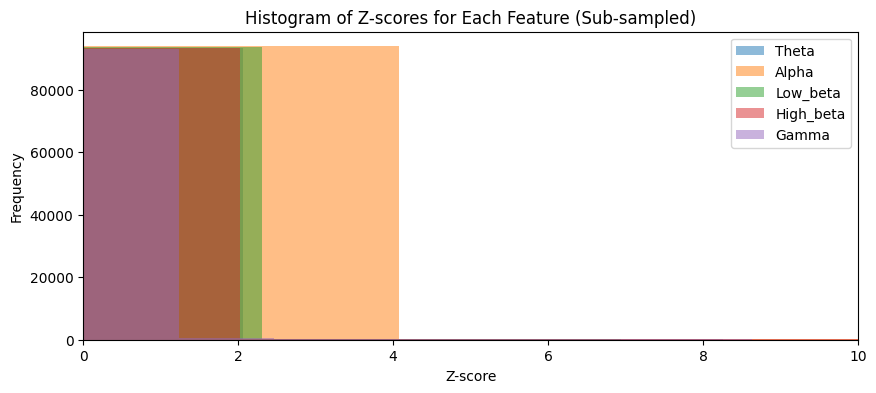

In [29]:
#TODO graficar histograma de z_scores y hacer lo que dice Facu

z_scores_df = pd.DataFrame(z_scores, columns=features)

# Sub-sample the data (for example, taking 30% of the original data)
sub_sampled_df = z_scores_df.sample(frac=0.5, random_state=1)  # Adjust the fraction as needed

# Plotting the sub-sampled data
plt.figure(figsize=(10, 4))
for column in sub_sampled_df.columns:
    plt.hist(sub_sampled_df[column], bins=30, alpha=0.5, label=column)

plt.title('Histogram of Z-scores for Each Feature (Sub-sampled)')
plt.xlabel('Z-score')
plt.ylabel('Frequency')
plt.xlim((0,10))
plt.legend()
plt.show()

In [8]:
# Combino num_samples de adhd y non adhd. Termino con num_samples*2 totales
# También marco en y_subset non adhd y a los adhd los diferencio por paciente
num_samples = 35000


adhd_df_list = []
for key, df in adhd_emotive.items():
    adhd_number = re.search(r'ADHD/(\d+)/', key).group(1)

    df['Label'] = f"ADHD_{adhd_number}"
    adhd_df_list.append(df)
combined_adhd_emotive = pd.concat(adhd_df_list, ignore_index=True)


non_adhd_df_list = []
for key, df in non_adhd_emotive.items():
    df['Label'] = 'Non_ADHD'
    non_adhd_df_list.append(df)
combined_non_adhd_emotive = pd.concat(non_adhd_df_list, ignore_index=True)

# features
features = ['Theta', 'Alpha', 'Low_beta', 'High_beta', 'Gamma']

# Estandarizar
scaler = StandardScaler()
x_adhd = scaler.fit_transform(combined_adhd_emotive[features])
x_non_adhd = scaler.fit_transform(combined_non_adhd_emotive[features])

# Labels
y_adhd = combined_adhd_emotive['Label']
y_non_adhd = combined_non_adhd_emotive['Label']

# TODO: agarrar la misma cantidad de cada uno de los adhd. Ahora mismo agarra random, pero como tienen diferente tamaño
# Terminamos analizando diferentes proporciones de los adhd
random.seed(42)
adhd_indices = random.sample(range(len(x_adhd)), num_samples)
non_adhd_indices = random.sample(range(len(x_non_adhd)), num_samples)

x_subset = np.concatenate((x_adhd[adhd_indices], x_non_adhd[non_adhd_indices]), axis=0)
y_subset = pd.concat([y_adhd.iloc[adhd_indices].reset_index(drop=True),
                      y_non_adhd.iloc[non_adhd_indices].reset_index(drop=True)])

y_subset_with_label = y_subset.copy()
y_subset_with_label = pd.DataFrame({'Label': y_subset_with_label})
y_subset_with_label['ADHD'] = y_subset_with_label['Label'].apply(lambda x: 0 if 'Non' in x else 1)


x_df = pd.DataFrame(data=x_subset, columns=features).reset_index(drop=True)
y_subset_with_label = y_subset_with_label.reset_index(drop=True)

ADHD_df = pd.concat([x_df, y_subset_with_label], axis=1)
ADHD_df = ADHD_df.drop(columns=['Label'])

# print(final_df['ADHD'].value_counts())
ADHD_df.head()

,Theta,Alpha,Low_beta,High_beta,Gamma,ADHD
0,-0.073176,-0.058215,-0.070679,-0.070678,-0.089206,1
1,-0.101447,-0.084072,-0.100066,-0.092408,-0.129292,1
2,-0.101355,-0.080493,-0.052301,-0.033055,0.214654,1
3,-0.102419,-0.084959,-0.103939,-0.099554,-0.145102,1
4,-0.102419,-0.084958,-0.103938,-0.099554,-0.145102,1


## Análisis preliminar de los datos

En esta sección, como el dataset ya ha sido pre-procesado y dividido en bandas de frecuencia se realizan directamente técnicas de reducción de dimensionalidad para sacar conclusiones acerca de las componentes más relevantes del problema.

### Ploteo

En principio se plotean dos señales aleatorias a modo de ejemplo, de cada clase de sujeto. Se observan diferencias sustanciales en la amplitud, especialmente de los ritmos theta.


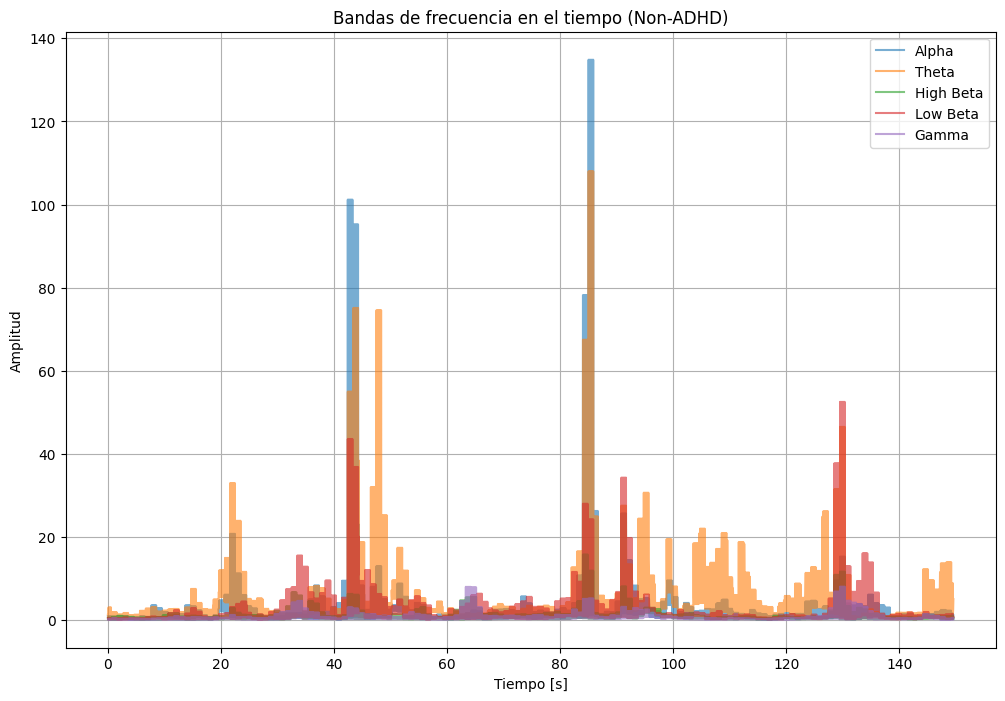

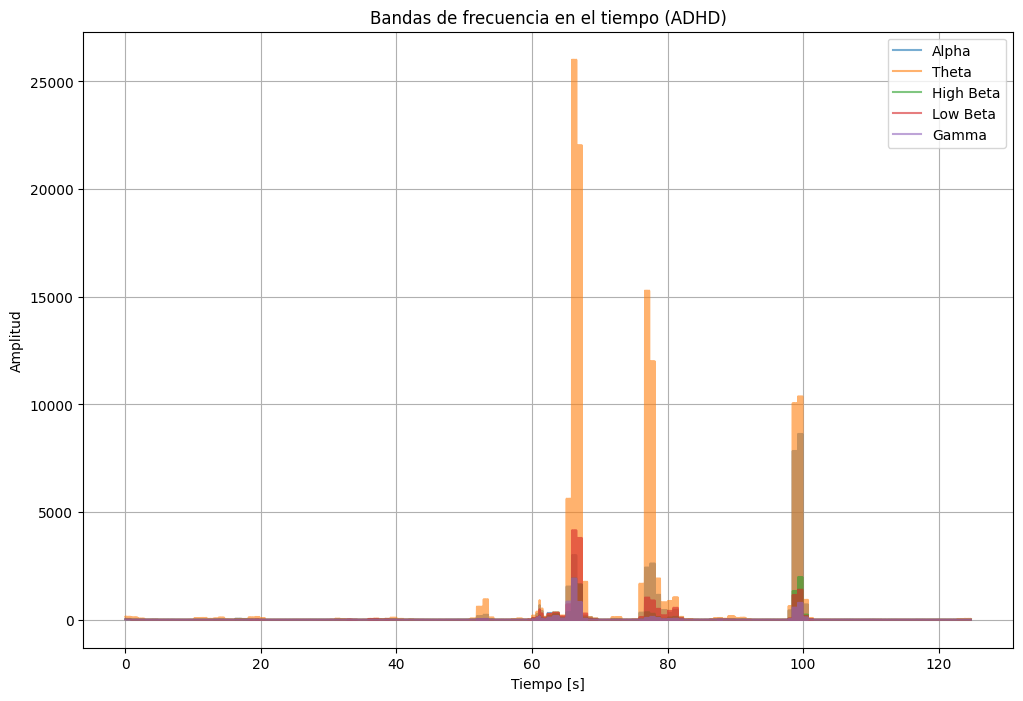

In [ ]:
values = non_adhd_emotive['Non-ADHD/2/Emotive/alaa_emo1.csv']
values2 = adhd_emotive['ADHD/10/Emotiv/emo zeynep 5.csv']

alpha = values['Alpha']
theta = values['Theta']
high_beta = values['High_beta']
low_beta = values['Low_beta']
gamma = values['Gamma']


fs = 125/5
t = values.index / fs

plt.figure(figsize=(12, 8))

plt.plot(t, alpha, label='Alpha', alpha=0.6)
plt.plot(t, theta, label='Theta', alpha=0.6)
plt.plot(t, high_beta, label='High Beta', alpha=0.6)
plt.plot(t, low_beta, label='Low Beta', alpha=0.6)
plt.plot(t, gamma, label='Gamma', alpha=0.6)


plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.title('Bandas de frecuencia en el tiempo (Non-ADHD)')
plt.legend()
plt.grid(True)

plt.show()

alpha2 = values2['Alpha']
theta2 = values2['Theta']
high_beta2 = values2['High_beta']
low_beta2 = values2['Low_beta']
gamma2 = values2['Gamma']

t = values2.index / fs


plt.figure(figsize=(12, 8))

plt.plot(t, alpha2, label='Alpha', alpha=0.6)
plt.plot(t, theta2, label='Theta', alpha=0.6)
plt.plot(t, high_beta2, label='High Beta', alpha=0.6)
plt.plot(t, low_beta2, label='Low Beta', alpha=0.6)
plt.plot(t, gamma2, label='Gamma', alpha=0.6)


plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.title('Bandas de frecuencia en el tiempo (ADHD)')
plt.legend()
plt.grid(True)

plt.show()

### Espectrogramas

Debido a que las señales ya han sido divididas en sus respectivas bandas de frecuencia, lo que no permite una reconstrucción fidedigna de los datos originales, no es posible realizar un espectrograma.

### Histogramas

In [ ]:
#TODO: podríamos hacer alguna clase de histograma para analizar las diferencias entre ADHD y no-ADHD de cada banda

### PCA

In [9]:
pca_model = PCA()
pca_zscore = pca_model.fit_transform(x)
explained_variance_ratio = pca_model.explained_variance_ratio_

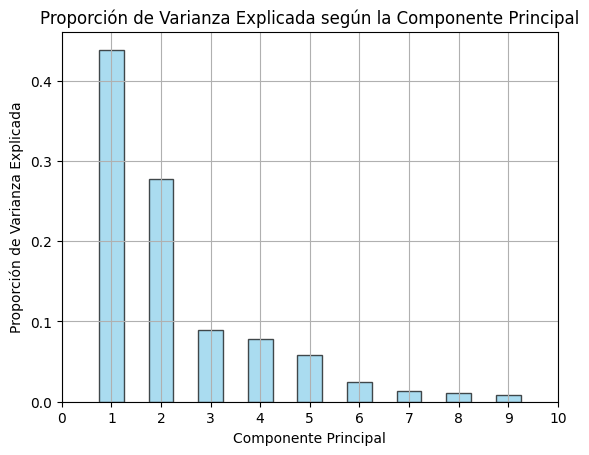

In [10]:
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, color='skyblue', width=0.5, edgecolor='black', alpha=0.7)
plt.xlabel('Componente Principal')
plt.ylabel('Proporción de Varianza Explicada')
plt.title('Proporción de Varianza Explicada según la Componente Principal')
plt.xlim(0, 10)
plt.xticks(range(0, 11))
plt.grid(True)
plt.show()

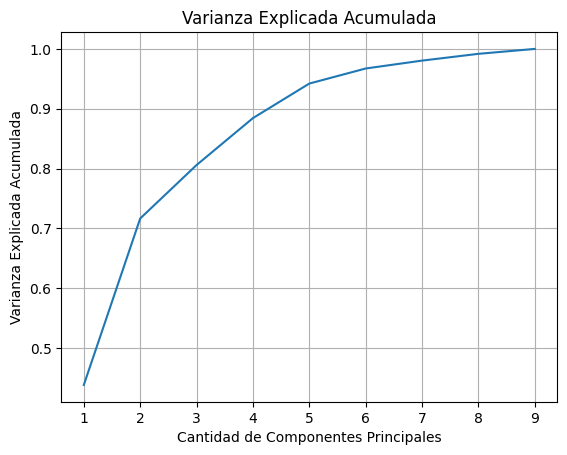

In [11]:
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio)
plt.xlabel('Cantidad de Componentes Principales')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada Acumulada')
plt.grid(True)
plt.show()

Con tres componentes se alcanza una varianza explicada acumulada del 80%.

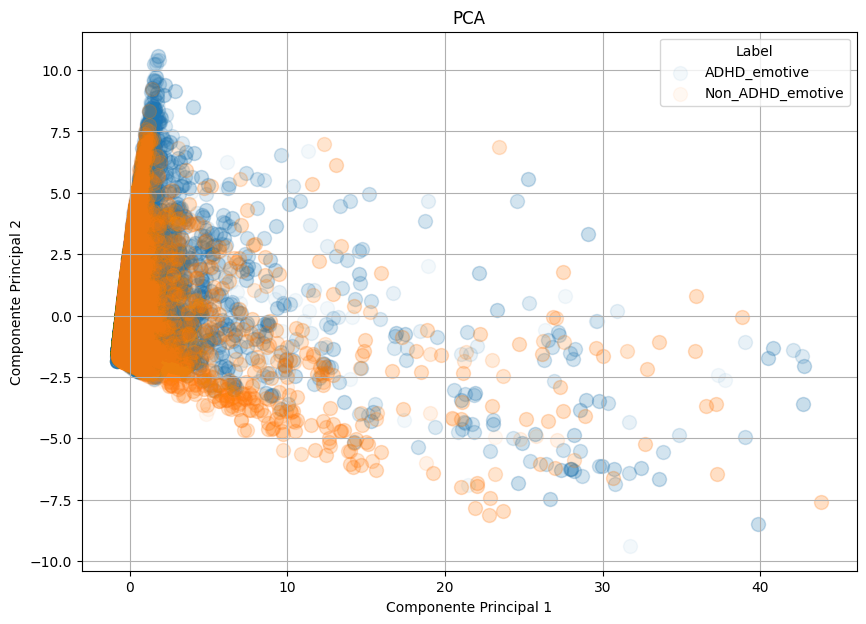

In [16]:
principal_components = pca_model.fit_transform(x)

principal_df = pd.DataFrame(data=principal_components, columns=[f'principal_component_{i+1}' for i in range(9)])

final_df = pd.concat([principal_df, y.reset_index(drop=True)], axis=1)

plt.figure(figsize=(10, 7))

for label in final_df['Label'].unique():
    subset = final_df[final_df['Label'] == label]
    plt.scatter(subset['principal_component_1'], subset['principal_component_2'], alpha=0.05, s=100, label=label)

plt.title('PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Label', loc='best')
plt.grid(True)
plt.show()

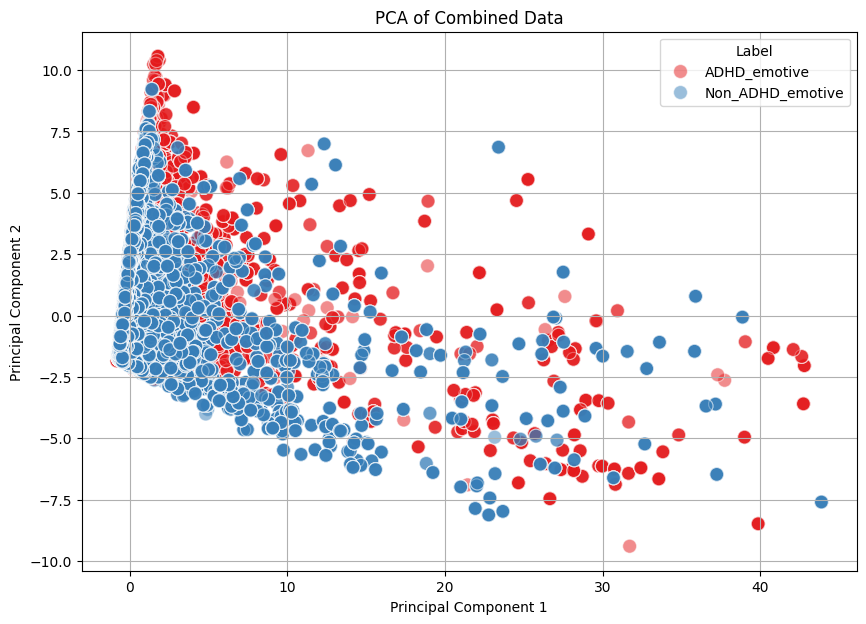

In [12]:
principal_components = pca_model.fit_transform(x)

principal_df = pd.DataFrame(data=pca_zscore, columns=[f'principal_component_{i+1}' for i in range(9)])

final_df = pd.concat([principal_df, y.reset_index(drop=True)], axis=1)


plt.figure(figsize=(10, 7))
sns.scatterplot(data=final_df, x='principal_component_1', y='principal_component_2', alpha=0.5, hue='Label', palette='Set1', s=100)
plt.title('PCA of Combined Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Label', loc='best')
plt.grid(True)
plt.show()

La separación entre los dos grupos a través de PCA no es buena.

### LDA

Por lo que entendemos, LDA puede graficar en una dimensión en nuestro caso. Toma el mínimo entre las features (5) y la cantidad de clases - 1 (si tomamos solo ADHD vs non-ADHD, es 1). Si hago este grafico con histograma no llego a nada lindo, porque los dos grupos concentran sus datos en casi el mismo lugar.

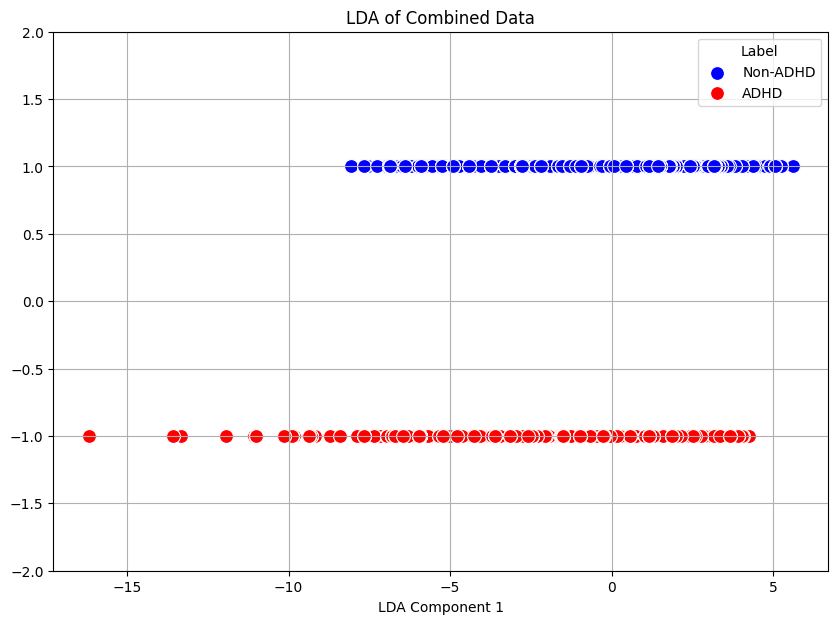

LDA coefficients:
[[ 0.05552603 -0.13680758  0.14329379 -0.25876456  0.09666058 -0.39510182
  -0.06675089  0.33186652  0.10765793]]

Explained variance ratio:
[1.]


In [17]:
lda = LDA(n_components=1)

lda_components = lda.fit_transform(x, y)

lda_df = pd.DataFrame(data=lda_components, columns=['lda_component_1'])

final_df = pd.concat([lda_df, y.reset_index(drop=True)], axis=1)

# Separo en base a label
non_adhd_data = final_df[final_df['Label'] == 'Non_ADHD_emotive']
adhd_data = final_df[final_df['Label'] == 'ADHD_emotive']

plt.figure(figsize=(10, 7))

sns.scatterplot(data=non_adhd_data, x='lda_component_1', y=np.ones(len(non_adhd_data)), color='blue', label='Non-ADHD', s=100)

sns.scatterplot(data=adhd_data, x='lda_component_1', y=-np.ones(len(adhd_data)), color='red', label='ADHD', s=100)

plt.title('LDA of Combined Data')
plt.xlabel('LDA Component 1')
plt.ylabel('')
plt.ylim(-2, 2)  # Hay outliers lejanos
plt.legend(title='Label', loc='best')
plt.grid(True)
plt.show()

print("LDA coefficients:")
print(lda.coef_)

explained_variance_ratio = lda.explained_variance_ratio_
print("\nExplained variance ratio:")
print(explained_variance_ratio)

### t-SNE

Por ahora estamos trabajando con subsets, ya que al trabajar con toda la data tarda demasiado. De todas formas, podemos ver que los datos se agrupan de acuerdo a ADHD y sin ADHD. Utilizando diferentes colores para los datos de cada sujeto con ADHD, también se puede observar que estos se agrupan según la persona. Los datos del sujeto 7 son los mas cercanos a los datos sin ADHD.


La idea de colorear los distintos sujetos de ADHD nace a partir de la voluntad de diferenciar a la persona que recibió tratamiento. En el paper se la nombra como P2 y sospechamos que se trata del sujeto 8, pero no estamos seguros ya que no se explicita en cuanto al dataset. Queremos comunicarnos con los investigadores para saber si nos lo pueden decir.


El primer t-SNE va a ser utilizando los ratios como features extras, mientras que el segundo sin ellos.

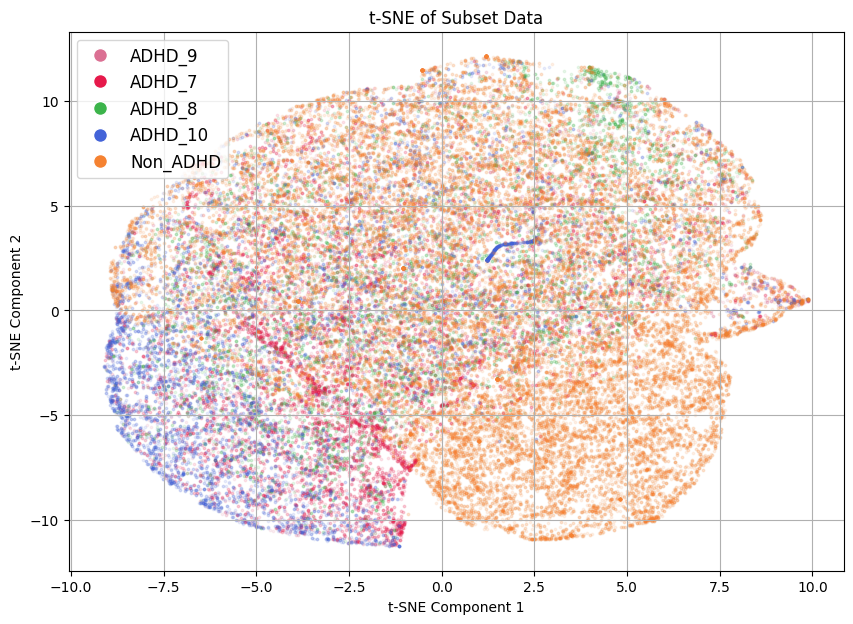

In [ ]:

tsne_model = TSNE(
    n_components=2,
    perplexity=50,
    learning_rate=200,
    n_iter=350
)


tsne_components = tsne_model.fit_transform(x_subset)

tsne_df = pd.DataFrame(data=tsne_components, columns=['tsne_component_1', 'tsne_component_2'])

# y_concatenated = pd.concat([y[:subset_size_each].reset_index(drop=True), y[-subset_size_each:].reset_index(drop=True)])
final_df_tsne = pd.concat([tsne_df, y_subset.reset_index(drop=True)], axis=1)

color_palette = {
    'ADHD_7': '#e6194b',  # Red
    'ADHD_8': '#3cb44b',  # Green
    'ADHD_9': '#db7093',  # Pink
    'ADHD_10': '#4363d8',  # Blue
    'Non_ADHD': '#f58231'  # Orange
}

plt.figure(figsize=(10, 7))
for label in final_df_tsne['Label'].unique():
    subset = final_df_tsne[final_df_tsne['Label'] == label]
    plt.scatter(
        subset['tsne_component_1'],
        subset['tsne_component_2'],
        label=label,
        c=color_palette[label],
        s=3,
        alpha=0.1
    )
plt.title('t-SNE of Subset Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
handles, labels = plt.gca().get_legend_handles_labels()
for i, handle in enumerate(handles):
    handles[i] = plt.Line2D([0], [0], marker='o', color='w', label=labels[i],
                            markerfacecolor=handle.get_facecolor()[0], markersize=10, alpha=1.0)
plt.legend(handles=handles, loc='best', fontsize=12)
plt.grid(True)
plt.show()

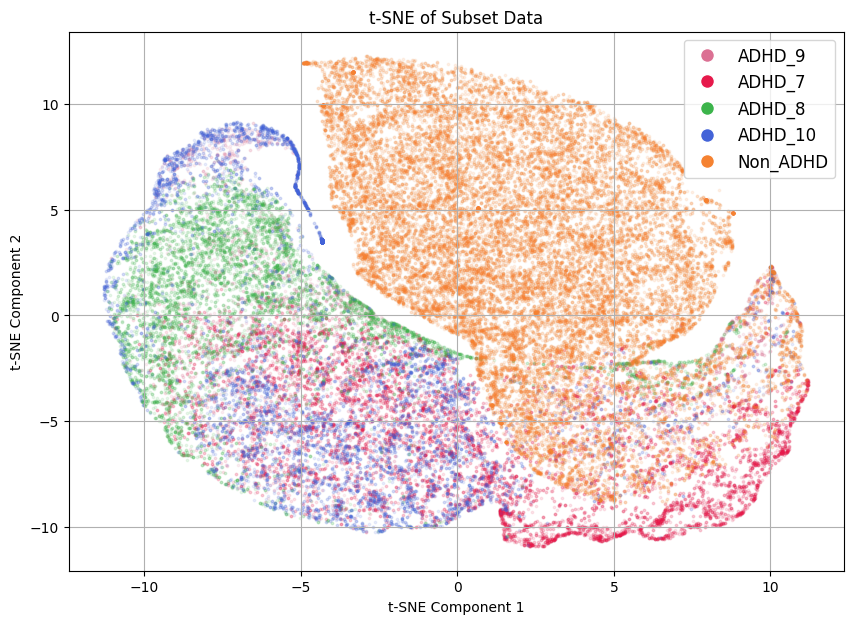

In [ ]:
tsne_model = TSNE(
    n_components=2,
    perplexity=50,
    learning_rate=200,
    n_iter=350
)


tsne_components = tsne_model.fit_transform(x_subset)

tsne_df = pd.DataFrame(data=tsne_components, columns=['tsne_component_1', 'tsne_component_2'])

final_df_tsne = pd.concat([tsne_df, y_subset.reset_index(drop=True)], axis=1)

color_palette = {
    'ADHD_7': '#e6194b',  # Red
    'ADHD_8': '#3cb44b',  # Green
    'ADHD_9': '#db7093',  # Pink
    'ADHD_10': '#4363d8',  # Blue
    'Non_ADHD': '#f58231'  # Orange
}

plt.figure(figsize=(10, 7))
for label in final_df_tsne['Label'].unique():
    subset = final_df_tsne[final_df_tsne['Label'] == label]
    plt.scatter(
        subset['tsne_component_1'],
        subset['tsne_component_2'],
        label=label,
        c=color_palette[label],
        s=3,
        alpha=0.1
    )
plt.title('t-SNE of Subset Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
handles, labels = plt.gca().get_legend_handles_labels()
for i, handle in enumerate(handles):
    handles[i] = plt.Line2D([0], [0], marker='o', color='w', label=labels[i],
                            markerfacecolor=handle.get_facecolor()[0], markersize=10, alpha=1.0)
plt.legend(handles=handles, loc='best', fontsize=12)
plt.grid(True)
plt.show()

### UMAP

Similarmente a t-SNE podemos ver que llegamos a un resultado prometedor. Por un lado tenemos a la mayoria de los puntos sin ADHD, mientras que en el otro lado tenemos a la mayoria de los puntos con ADHD. TODO check si es correcto agregarle ruido, ya que me lo pide al utilizar verbose.

Como en t-SNE, el primer grafico se realizó utilizando los ratios, mientras que el segundo como en la entrega anterior sin ellos.

<bound method DataFrame.info of        umap_component_1  umap_component_2
0              5.324587          4.128060
1              3.289147         12.833695
2             -0.498403         12.039610
3              3.913880          7.961190
4             -3.320976         11.206998
...                 ...               ...
69995          7.165683          5.503503
69996          8.935292          4.990805
69997          8.117649         12.364820
69998          4.358315          4.925956
69999         -3.554660          3.207242

[70000 rows x 2 columns]>
<bound method DataFrame.info of        umap_component_1  umap_component_2     Label
0              5.324587          4.128060    ADHD_9
1              3.289147         12.833695    ADHD_7
2             -0.498403         12.039610    ADHD_7
3              3.913880          7.961190    ADHD_8
4             -3.320976         11.206998    ADHD_8
...                 ...               ...       ...
69995          7.165683          5.503503

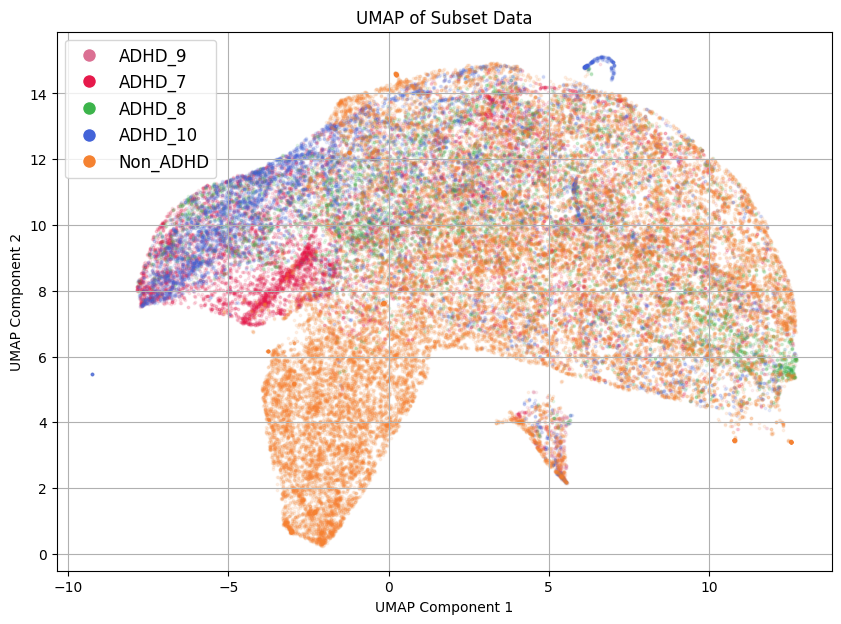

In [ ]:
noise = np.random.normal(0, 0.0001, size=x_subset.shape)
x_subset = x_subset + noise

umap_model = UMAP(
    n_components=2,
    n_neighbors=150,
    min_dist=0.2,
    metric='euclidean',
    learning_rate=0.5,
    n_epochs=300,
    n_jobs=-1,
    verbose=False
)

umap_components = umap_model.fit_transform(x_subset)

umap_df = pd.DataFrame(data=umap_components, columns=['umap_component_1', 'umap_component_2'])
print(umap_df.info)

final_df_umap = pd.concat([umap_df, y_subset.reset_index(drop=True)], axis=1)

print(final_df_umap.info)

color_palette = {
    'ADHD_7': '#e6194b',  # Red
    'ADHD_8': '#3cb44b',  # Green
    'ADHD_9': '#db7093',  # Pink
    'ADHD_10': '#4363d8',  # Blue
    'Non_ADHD': '#f58231'  # Orange
}

plt.figure(figsize=(10, 7))
for label in final_df_umap['Label'].unique():
    subset = final_df_umap[final_df_umap['Label'] == label]
    plt.scatter(
        subset['umap_component_1'],
        subset['umap_component_2'],
        label=label,
        c=color_palette[label],
        s=3,
        alpha=0.1
    )
plt.title('UMAP of Subset Data')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
handles, labels = plt.gca().get_legend_handles_labels()
for i, handle in enumerate(handles):
    handles[i] = plt.Line2D([0], [0], marker='o', color='w', label=labels[i],
                            markerfacecolor=handle.get_facecolor()[0], markersize=10, alpha=1.0)

plt.legend(handles=handles, loc='best', fontsize=12)
plt.grid(True)
plt.show()

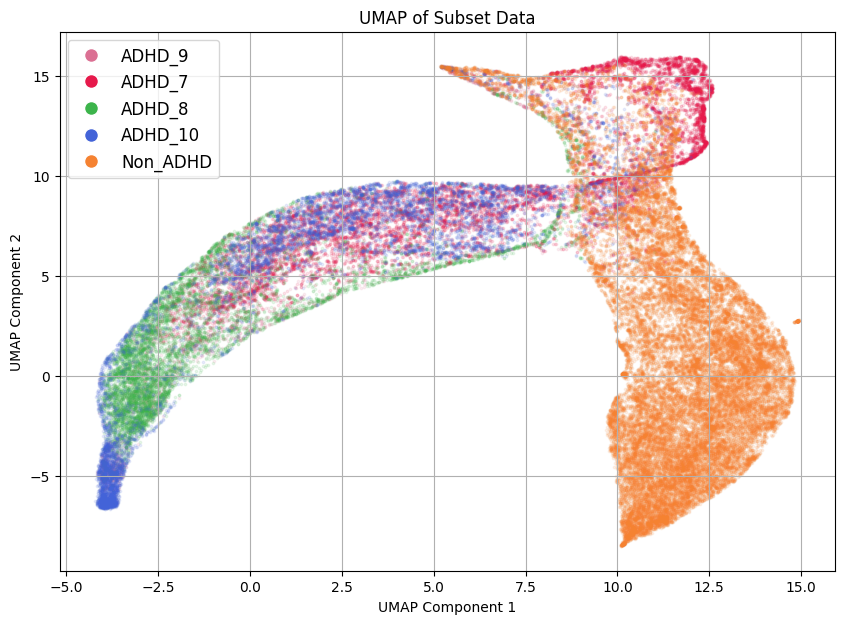

In [ ]:
noise = np.random.normal(0, 0.0001, size=x_subset.shape)
x_subset = x_subset + noise

umap_model = UMAP(
    n_components=2,
    n_neighbors=150,
    min_dist=0.2,
    metric='euclidean',
    learning_rate=0.5,
    n_epochs=300,
    n_jobs=-1,
    verbose=False
)

umap_components = umap_model.fit_transform(x_subset)

umap_df = pd.DataFrame(data=umap_components, columns=['umap_component_1', 'umap_component_2'])

final_df_umap = pd.concat([umap_df, y_subset.reset_index(drop=True)], axis=1)


color_palette = {
    'ADHD_7': '#e6194b',  # Red
    'ADHD_8': '#3cb44b',  # Green
    'ADHD_9': '#db7093',  # Pink
    'ADHD_10': '#4363d8',  # Blue
    'Non_ADHD': '#f58231'  # Orange
}

plt.figure(figsize=(10, 7))
for label in final_df_umap['Label'].unique():
    subset = final_df_umap[final_df_umap['Label'] == label]
    plt.scatter(
        subset['umap_component_1'],
        subset['umap_component_2'],
        label=label,
        c=color_palette[label],
        s=3,
        alpha=0.1
    )
plt.title('UMAP of Subset Data')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
handles, labels = plt.gca().get_legend_handles_labels()
for i, handle in enumerate(handles):
    handles[i] = plt.Line2D([0], [0], marker='o', color='w', label=labels[i],
                            markerfacecolor=handle.get_facecolor()[0], markersize=10, alpha=1.0)

plt.legend(handles=handles, loc='best', fontsize=12)
plt.grid(True)
plt.show()

### Conclusiones acerca de los datos

La separación en los dos grupos a clasificar es buena para UMAP y t-SNE, no así para los métodos de PCA y LDA. Esto denota una relación de no-linealidad entre la separación ADHD y no-ADHD. Además, puede que PCA y LDA no sean técnicas adecuadas para abordar la complejidad de los datos.

## Clasificación

### Análisis de correlación

Se observa a continuación como se modifican los *heatmaps* según el método seleccionado para el cálculo de la correlación. Los valores de la correlación entre la presencia de ADHD y los features de interés para Pearson son muy bajos, mientras que para Spearman y Kendall son elevados. Esto es consistente con lo observado en las técnicas de reducción de dimensiones, es decir que hay una relación de no-linealidad.

In [18]:
ADHD_df.head()

,Theta,Alpha,Low_beta,High_beta,Gamma,ADHD
0,-0.073176,-0.058215,-0.070679,-0.070678,-0.089206,1
1,-0.101447,-0.084072,-0.100066,-0.092408,-0.129292,1
2,-0.101355,-0.080493,-0.052301,-0.033055,0.214654,1
3,-0.102419,-0.084959,-0.103939,-0.099554,-0.145102,1
4,-0.102419,-0.084958,-0.103938,-0.099554,-0.145102,1


<Axes: >

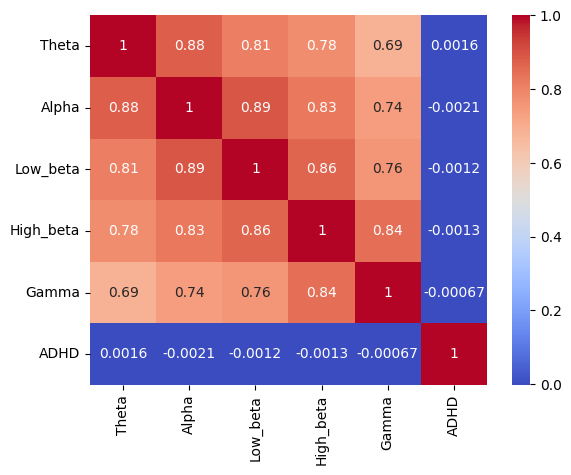

In [25]:
from matplotlib import cm

sns.heatmap(ADHD_df.corr(method='pearson'), cmap=cm.coolwarm, annot = True)

<Axes: >

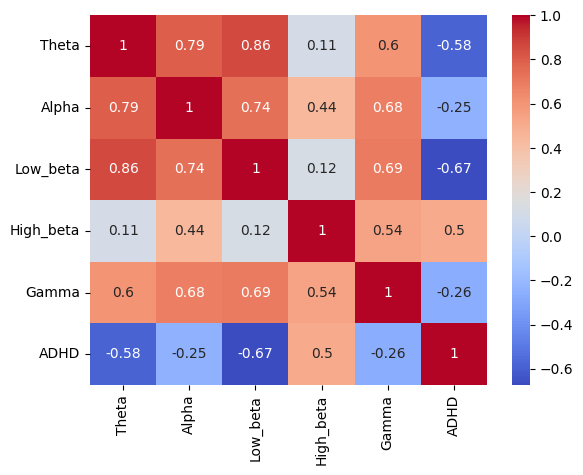

In [26]:
sns.heatmap(ADHD_df.corr(method='spearman'), cmap=cm.coolwarm, annot = True)

<Axes: >

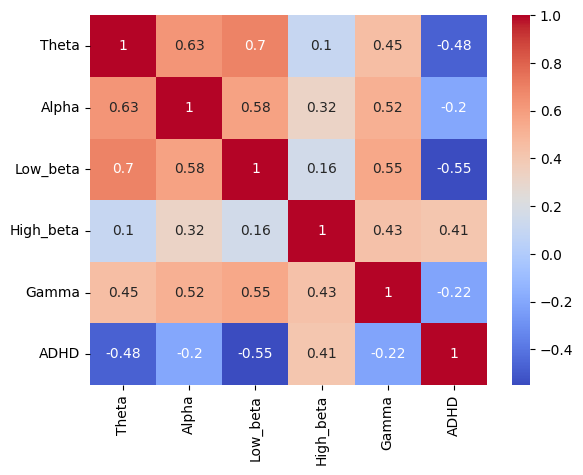

In [27]:
sns.heatmap(ADHD_df.corr(method='kendall'), cmap=cm.coolwarm, annot = True)

### Support Vector Machine

In [ ]:
def stratified_sample_data(data_dict, label):
    df_list = []
    for key, df in data_dict.items():
        df['Label'] = label
        df_list.append(df)
    combined_df = pd.concat(df_list, ignore_index=True)
    return combined_df

# Sample training data (ADHD and non-ADHD)
combined_adhd_train = stratified_sample_data(adhd_emotive_train, 'ADHD')
combined_non_adhd_train = stratified_sample_data(non_adhd_emotive_train, 'Non_ADHD')

# Sample testing data (only non-ADHD)
combined_adhd_test = stratified_sample_data(adhd_emotive_test, 'ADHD')

# Features to use
features = ['Theta', 'Alpha', 'Low_beta', 'High_beta', 'Gamma', 'Theta/High_beta', 'Theta/Low_beta', 'Alpha/High_beta', 'Alpha/Low_beta']

# Standardize
scaler = StandardScaler()

# Training data
x_adhd_train = scaler.fit_transform(combined_adhd_train[features])
x_non_adhd_train = scaler.fit_transform(combined_non_adhd_train[features])

# Labels for training data
y_adhd_train = combined_adhd_train['Label']
y_non_adhd_train = combined_non_adhd_train['Label']

# Combine training data
x_train = np.concatenate((x_adhd_train, x_non_adhd_train), axis=0)
y_train = pd.concat([y_adhd_train, y_non_adhd_train]).reset_index(drop=True)

# Testing data (only ADHD)
x_test = scaler.transform(combined_adhd_test[features])
y_test = combined_adhd_test['Label']

# Prepare final training and testing DataFrames
y_train_with_label = pd.DataFrame({'Label': y_train})
y_train_with_label['ADHD'] = y_train_with_label['Label'].apply(lambda x: 0 if 'Non' in x else 1)

y_test_with_label = pd.DataFrame({'Label': y_test})
y_test_with_label['ADHD'] = y_test_with_label['Label'].apply(lambda x: 0 if 'Non' in x else 1)

x_train_df = pd.DataFrame(data=x_train, columns=features).reset_index(drop=True)
x_test_df = pd.DataFrame(data=x_test, columns=features).reset_index(drop=True)

train_df = pd.concat([x_train_df, y_train_with_label.reset_index(drop=True)], axis=1).drop(columns=['Label'])
test_df = pd.concat([x_test_df, y_test_with_label.reset_index(drop=True)], axis=1).drop(columns=['Label'])

train_df.head()
test_df.head()

,Theta,Alpha,Low_beta,High_beta,Gamma,Theta/High_beta,Theta/Low_beta,Alpha/High_beta,Alpha/Low_beta,ADHD
0,0.022734,-0.006533,-0.026398,-0.002921,-0.017935,0.284379,0.664353,0.075451,0.314584,1
1,0.015653,0.012640,-0.010750,0.011757,-0.046436,0.147944,0.253101,0.171071,0.233535,1
2,-0.012093,-0.027039,-0.023690,-0.023256,-0.044864,0.168522,0.164576,-0.012238,-0.121274,1
3,-0.009071,-0.015701,-0.011032,0.027120,0.024130,-0.055696,0.015037,-0.251520,-0.159730,1
4,0.018031,-0.014004,-0.037692,-0.039426,-0.073050,0.643746,1.010173,0.483405,0.568855,1


In [ ]:
window_size = 5

# Usando windows como en el paper
def create_windowed_data(df, window_size):
    segments = []
    labels = []

    for i in range(0, len(df) - window_size + 1, window_size):
        segment = df.iloc[i:i + window_size]  # Extract a window of size window_size
        features = segment.drop(columns=['ADHD']).values.flatten()  # Extract features from the window
        label = segment['ADHD'].values[0]  # Assign label based on the first sample in the window
        segments.append(features)
        labels.append(label)

    return np.array(segments), np.array(labels)

x_train_windowed, y_train_windowed = create_windowed_data(train_df, window_size)

x_test_windowed, y_test_windowed = create_windowed_data(test_df, window_size)

svm_model_windowed = SVC(kernel='rbf', C=3.0, random_state=42)
svm_model_windowed.fit(x_train_windowed, y_train_windowed)

y_pred_windowed = svm_model_windowed.predict(x_test_windowed)

accuracy_windowed = accuracy_score(y_test_windowed, y_pred_windowed)
conf_matrix_windowed = confusion_matrix(y_test_windowed, y_pred_windowed)
class_report_windowed = classification_report(y_test_windowed, y_pred_windowed)

print("Accuracy (Windowed):", accuracy_windowed)
print("Confusion Matrix (Windowed):\n", conf_matrix_windowed)
print("Classification Report (Windowed):\n", class_report_windowed)



Accuracy (Windowed): 0.2275485436893204
Confusion Matrix (Windowed):
 [[   0    0]
 [1273  375]]
Classification Report (Windowed):
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.23      0.37      1648

    accuracy                           0.23      1648
   macro avg       0.50      0.11      0.19      1648
weighted avg       1.00      0.23      0.37      1648



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# TODO: df con una columna que le de un ID a cada sujeto (puede ser el nombre de la carpeta)
# así separamos los datos por paciente

from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

X_train = train_df[features]
y_train = train_df['ADHD']
X_test = test_df[features]
y_test = test_df['ADHD']


svm_model = SVC(kernel='rbf', C=3, random_state=42)
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Accuracy: 0.4784654281631307
Confusion Matrix:
 [[ 7330 14720]
 [ 9002 14433]]
Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.33      0.38     22050
           1       0.50      0.62      0.55     23435

    accuracy                           0.48     45485
   macro avg       0.47      0.47      0.47     45485
weighted avg       0.47      0.48      0.47     45485

